## Pre-processing MAST rhythmic data

This is an auxiliary notebook which targets at the preparation of data towards the automatic assessment analysis. It requires the data downloaded using the _DownloadDataFromMASTDataset_ notebook, so make sure to go over that notebook before executing this one.

The next instructions will guide us on the tasks of extracting onset times information from both references and performances, scaling performances according to their respective references and converting the onset times into a binary representation which is more suitable for the application of distance measures

First, let's import all Essentia's required modules, set a few audio processing parameters and create a couple of functions for audio loading and onset extraction

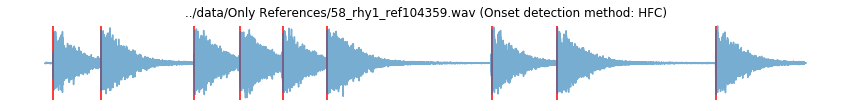

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from essentia.standard import *
from essentia import Pool, array

DATA_FOLDER = "../data/"

# audio loading parameters
SAMPLE_RATE = 44100
WINDOW_SIZE = 1024
HOP_SIZE = 512
WINDOWING_METHOD = 'hann'

# onset detection parameters
ONSET_DETECTION_METHOD = 'hfc'

# used for quantizing purposes
ONSET_N_OF_BINS = 60

def _load_file_as_monophonic_waveform(file_path):
    fs = SAMPLE_RATE

    x = MonoLoader(filename = file_path, sampleRate = fs)()
    return x/np.max(np.abs(x))

def _extract_onset_vectors(waveform):
    od = OnsetDetection(method=ONSET_DETECTION_METHOD)
    w = Windowing(type = WINDOWING_METHOD)
    fft = FFT()
    c2p = CartesianToPolar()
    onsets = Onsets()

    pool = Pool()
    for frame in FrameGenerator(waveform, frameSize = WINDOW_SIZE, hopSize = HOP_SIZE):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features', od(mag, phase))

    onsets = onsets(array([pool['features']]),[1])
    return onsets

# examples
file_name = os.path.join(DATA_FOLDER, 'Only References', '58_rhy1_ref104359.wav')

x = _load_file_as_monophonic_waveform(file_name)
t = np.arange(len(x))/float(SAMPLE_RATE) # for plotting purposes
onsets_hfc = _extract_onset_vectors(x)

plt.figure(figsize=(15,1.5))
plt.plot(t ,x, alpha=0.6)
plt.title("%s (Onset detection method: HFC)" % file_name);
plt.axis('off')
plt.vlines(onsets_hfc, -1, 1, 'r')

plt.show()

Above we can see the waveform of a loaded audio along with its onset times obtained from the signal (red lines)

Next, we extract onset times for all references and performances, writing the outputs into an auxiliary file for further use. After executing the following one can check the onset times in a file inside each data folder

In [3]:
def extract_onsets(base_dir, list_files, output_file):
    with open(list_files, 'r') as listfiles:
        with open(output_file, 'w') as output:
            for audio_file in listfiles.readlines():
                audio_file = audio_file.strip()
                audio_file_full_path = '%s%s' % (base_dir, audio_file)

                w = _load_file_as_monophonic_waveform(audio_file_full_path)
                onsets = _extract_onset_vectors(w)
                
                output.write('%s\n' % " ".join(list(str(x) for x in onsets)))

# extracting onset times for performances
base_dir_performances = os.path.join(DATA_FOLDER, 'Only Performances/') 
list_files_performances = os.path.join(DATA_FOLDER, 'Only Performances/listperformances')
output_file_performances = os.path.join(DATA_FOLDER, 'Only Performances/MAST Onsets [Performances]')

extract_onsets(base_dir_performances, list_files_performances, output_file_performances)

# extracting onset times for references
base_dir_references = os.path.join(DATA_FOLDER, 'Only References/')
list_files_references = os.path.join(DATA_FOLDER, 'Only References/listreferences')
output_file_references = os.path.join(DATA_FOLDER, 'Only References/MAST Onsets [References]')

extract_onsets(base_dir_references, list_files_references, output_file_references)

# example
with open(os.path.join(DATA_FOLDER, 'Only References/MAST Onsets [References]')) as onsets_file:
    for i in range(10):
        print(onsets_file.readline().strip())


0.336689 0.615329 1.10295 1.40481 1.78794 2.14785 2.77478 3.01859 3.2624 3.52943 4.02866
0.02322 0.2322 0.812698 1.11456 1.40481 2.02014 2.64707 3.27401 3.90095 4.20281 4.50467 5.10839
0.0696599 0.557279 1.01007 1.24227 1.47447 1.93887 2.14785 2.38005 2.83283 3.05342 3.27401 3.4946 3.70358 3.92417 4.16798
0.0348299 0.278639 0.963628 1.01007 1.33515 1.79955 2.2059 3.16952 3.44816 3.69197 3.93578 4.4234
0.313469 0.592109 1.42803 1.69506 1.95048 2.54259 2.93732 3.28562 4.35374
0.20898 0.441179 0.650159 0.870748 1.10295 1.52091 1.96209 2.39166 2.798 3.00698 3.23918 3.44816 3.65714 4.08671
0.16254 0.684989 1.21905 2.05497 2.33361 2.60063 2.85605 3.09986 3.65714 3.93578 4.21442 5.02712
0.0464399 0.336689 0.893968 1.17261 1.42803 1.69506 2.6819 3.07664 4.02866
0.2322 0.359909 0.975238 1.2771 1.59057 2.2059 2.83283 3.11147 3.42494 4.05188 4.66721
0.2322 0.359909 0.975238 1.2771 1.59057 2.2059 2.83283 3.11147 3.42494 4.05188 4.66721


We then scale performances onsets times according to their reference lengths. This is a necessary step since students were allowed to play in a different tempo from the masters. Tempo-independence is achieved in our sample by scaling performances according to a scale factor. 

Afterwards, we convert this numeric/unquantized representation into a binary/quantized representation. In this new data representation, onset times are disposed into bins in such manner that a 1 in the _i-eth_ bin translates into the presence of a beat in the _i-eth_ time window. After executing the following one can check the unquantized representations of the onset times in a file inside the data folders. For the references files, this unquantized data is also scaled.

In [7]:
def rescale_and_make_bins(performances_file, references_file):
    with open(performances_file, 'r') as perf_onsets_file:
        with open(references_file, 'r') as ref_onsets_file:
            perfs_onsets = perf_onsets_file.readlines()
            refs_onsets = ref_onsets_file.readlines()
            with open('%s [BINS]' % performances_file, 'w') as performances_file_bin,\
                 open('%s [BINS]' % references_file, 'w') as references_file_bin,\
                 open('%s [SCALING DATA]' % performances_file, 'w') as performances_scaling_file,\
                 open('%s [SCALING DATA]' % references_file, 'w') as references_scaling_file:
                for i in range(len(perfs_onsets)):
                    perf_onsets = [ float(x) for x in perfs_onsets[i].strip().split(" ") ]

                    perf_first_onset = perf_onsets[0]
                    perf_last_onset = perf_onsets[-1]
                    
                    ref_onsets = [ float(x) for x in refs_onsets[i].strip().split(" ") ]
                    ref_first_onset = ref_onsets[0]
                    ref_last_onset = ref_onsets[-1]                  

                    # setting onset boundaries from first to last onsets
                    perf_onsets = [ x - perf_onsets[0] for x in perf_onsets ]                   
                    ref_onsets = [ x - ref_onsets[0] for x in ref_onsets ]
                    

                    # re-scaling performance to match reference tempo
                    perf_inner_duration = perf_onsets[-1] - perf_onsets[0]
                    ref_inner_duration = ref_onsets[-1] - ref_onsets[0]   
                    
           
                    time_rescaling_factor = ((perf_inner_duration - ref_inner_duration) / perf_inner_duration)
                    
                    # onset window size is defined as a function of the audio duration
                    window_size = ref_inner_duration / ONSET_N_OF_BINS
                    
                    # saving scaling info for plotting purposes
                    # first onset / last onset / inner duration / scaling factor (only for performances)
                    performances_scaling_file.write('%.8f %.8f %.8f %.8f %.8f\n' % (perf_first_onset,perf_last_onset, perf_inner_duration, time_rescaling_factor, window_size))
                    references_scaling_file.write('%.8f %.8f %.8f %.8f\n' % (ref_first_onset,ref_last_onset, ref_inner_duration, window_size))

                    rescaled_perf_onsets = [adjust_onset_by_rate(onset, time_rescaling_factor) for onset in perf_onsets]
           
                    performance_onset_bins = make_bins(rescaled_perf_onsets, window_size)
                    performances_file_bin.write('%s\n' % " ".join([str(x) for x in performance_onset_bins]))

                    references_onset_bins = make_bins(ref_onsets, window_size)
                    references_file_bin.write('%s\n' % " ".join([str(x) for x in references_onset_bins]))


def make_bins(onset_times, window_size):
    bins = []
        
    for i in range(int(ONSET_N_OF_BINS)):
        for onset_time in onset_times:
            if i == ONSET_N_OF_BINS-1:
                if window_size*(i - 0.5) <= onset_time <= window_size*(i + float('inf')):
                    bins.append(1)
                    break
                else:
                    continue
            else:                
                if window_size*(i - 0.5) <= onset_time <= window_size*(i + 0.5):
                    bins.append(1)
                    break
        else:
            bins.append(0)

    return bins

def adjust_onset_by_rate(onset, time_rescaling_factor):
    return onset - (onset * time_rescaling_factor)

# running functions over data
rescale_and_make_bins(os.path.join(DATA_FOLDER, 'Only Performances/MAST Onsets [Performances]'),
                         os.path.join(DATA_FOLDER, 'Only References/MAST Onsets [References]'))

# example
with open(os.path.join(DATA_FOLDER, 'Only References/MAST Onsets [References] [BINS]')) as onsets_file:
    for i in range(10):
        print(onsets_file.readline().strip().replace(" ",""))

100001000000100001000000100001000000000010001000100010000001
101000000100010010000000100000010000001000000010010001000001
100000010000001001000100000100100010000010001001001001001001
100100000000010000100000100000100000000000010001001001000001
100010000000000001000100100000000100000100001000000000000001
100010010010001000001000000100000010000010010001001001000001
100000100000010000000001000100100100100000010001001000000001
100010000000010001000100010000000000000010000010000000000001
101000000010001000100000000100000001000100010000000010000001
101000000010001000100000000100000001000100010000000010000001


Finally, we plot a few audio samples aside with their unquantized and quantized onsets plotted in the form of stems. The main goal of this visualization is to ensure that both onset representations are aligned with audio events (i.e. the waveform)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


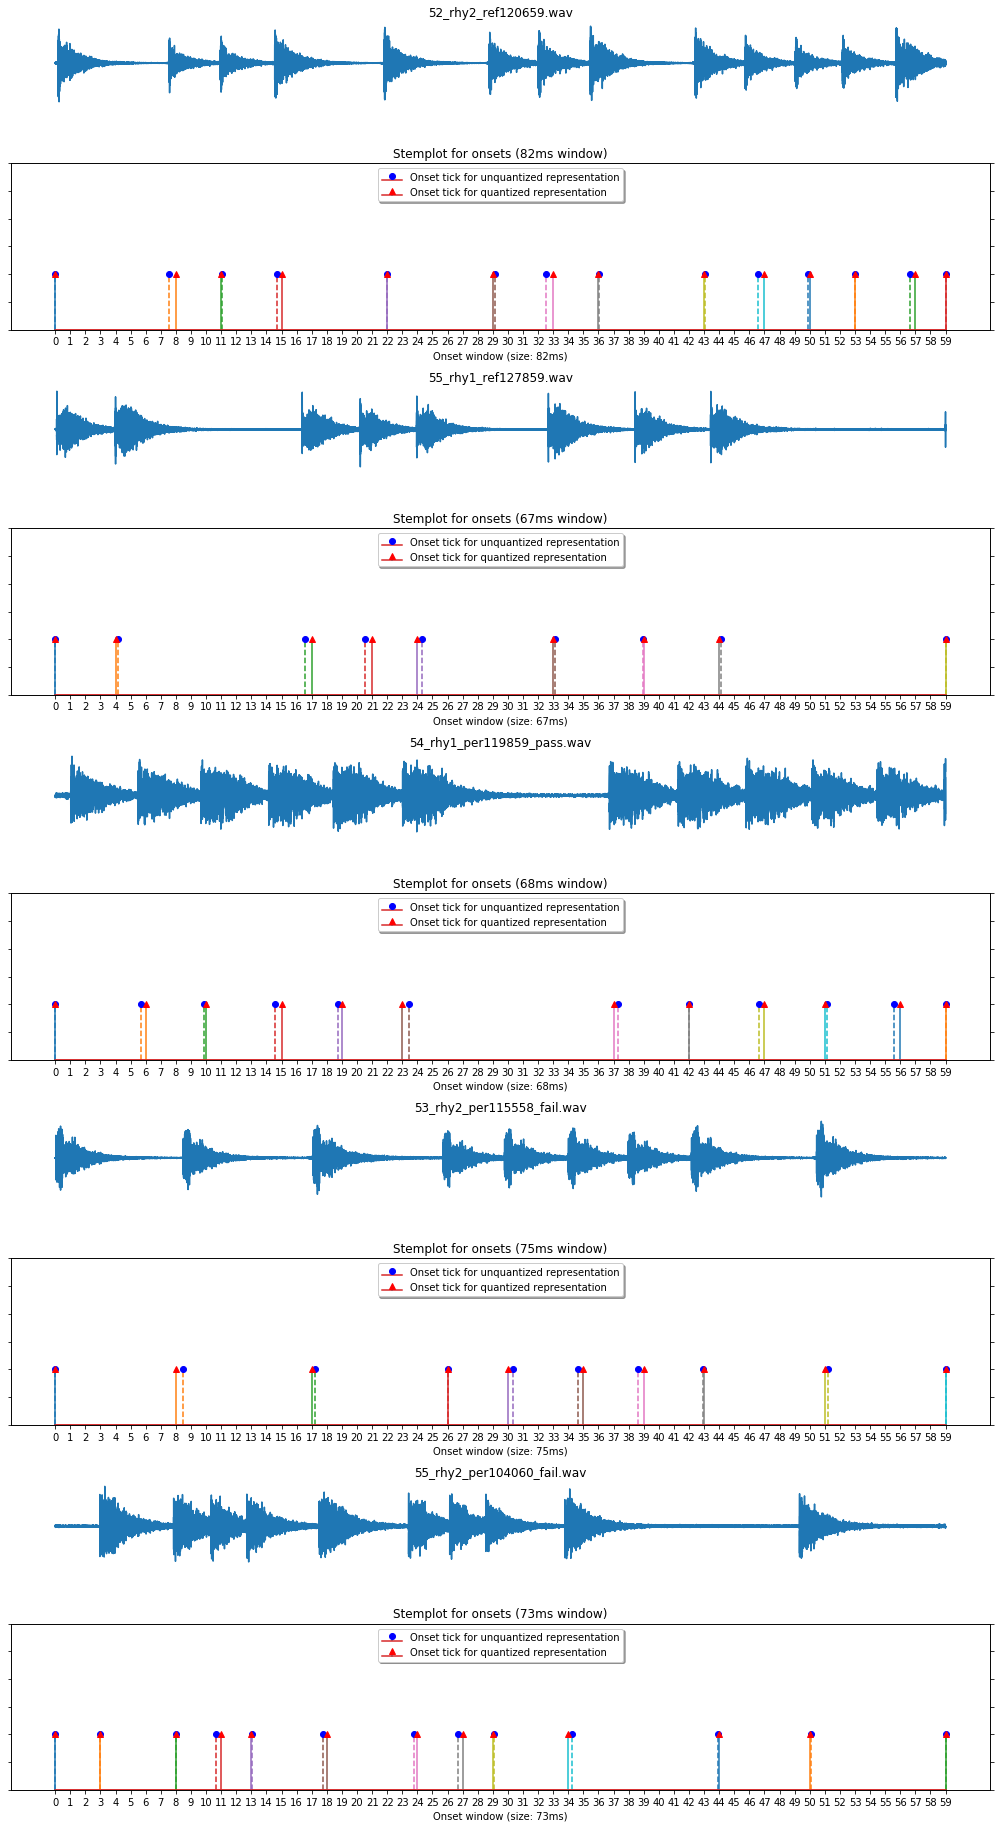

In [14]:
audio_samples = ['Only References/52_rhy2_ref120659.wav', 'Only References/55_rhy1_ref127859.wav',
                'Only Performances/54_rhy1_per119859_pass.wav', 'Only Performances/53_rhy2_per115558_fail.wav',
                'Only Performances/55_rhy2_per104060_fail.wav']

## Auxiliar functions ##

# gets the audio index
def get_audio_index(file, performance_type):
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), 'list%ss' % performance_type)
    with open(file_path, 'r') as list_files:
        files = [x.strip() for x in list_files.readlines()]
        return files.index(file)
    
# gets the auxiliar info (previously stored data) given a file and the info file format    
def get_info(file, performance_type, info_file_format):   
    index = get_audio_index(file, performance_type)
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), info_file_format.format(performance_type.capitalize()))
    
    with open(file_path, 'r') as infos:
        info = infos.readlines()[index]
        return [float(x) for x in info.split()]
    
       

f, axarr = plt.subplots(len(audio_samples) * 2,1,figsize=(14, len(audio_samples)*5.1), gridspec_kw = {'height_ratios':len(audio_samples) * [1,2] })
idx = 0

for audio in audio_samples:
    file_name = audio.split('/')[1]    
  
    ## Plotting weveform ###
    
    w = _load_file_as_monophonic_waveform(os.path.join(DATA_FOLDER, audio))
    
    # filtering waveform to range from first to last onsets
    # scaling_info[0] is the first onset. scaling_info[1] is the last one
    scaling_info = get_info(file_name, 'reference' if 'ref' in file_name else 'performance', 'MAST Onsets [{}s] [SCALING DATA]')
    window_size_for_audio = scaling_info[3] if 'ref' in file_name else scaling_info[4]    

    w = w[round(scaling_info[0] * SAMPLE_RATE) : round(scaling_info[1] * SAMPLE_RATE)]
    
    t=np.arange(len(w))   

    axarr[idx].plot(t,w)
    axarr[idx].axis('off')
    axarr[idx].set_title(file_name);
    
    ## Plotting stems from both quantized and unquantized onsets ###   
    idx+=1
    
    unquantized_onsets = get_info(file_name, 'reference' if 'ref' in file_name else 'performance', 'MAST Onsets [{}s]')

    # scaling quantized onsets so the first onset is in moment 0
    unquantized_onsets = [x - scaling_info[0] for x in unquantized_onsets] 
    # scaling quantized onsets to match reference tempo
    if 'per' in file_name:
        unquantized_onsets = [adjust_onset_by_rate(onset, scaling_info[3]) for onset in unquantized_onsets]    
    
    quantized_onsets = get_info(file_name, 'reference' if 'ref' in file_name else 'performance', 'MAST Onsets [{}s] [BINS]')

    # Calculating quantized stems/windows/boundaries
    # e.g a 1 in a index #9 (zero indexed) means a beat in the window #10
    # (boundaries: 0,9s - 1s). window size is 200ms
    quantized_stems = []    
    for i in range(len(quantized_onsets)):
        if quantized_onsets[i]:
            quantized_stems.append(i)   
            
    # Calculating unquantized stems/windows/boundaries
    # e.g an onset in moment 0.95s means  beat with boundaries [0,9s - 1s] which 
    # translates to window/stem 10
    unquantized_stems = [min((unquantized_onset / window_size_for_audio), ONSET_N_OF_BINS - 1) for unquantized_onset in unquantized_onsets]    
    
    axarr[idx].set_title('Stemplot for onsets (%ims window)' % int(window_size_for_audio*1000)) 
    axarr[idx].set_xlabel("Onset window (size: %ims)" % int(window_size_for_audio*1000))
    axarr[idx].set_xticks(range(max(max(quantized_stems), round(max(unquantized_stems))) + 1))
    axarr[idx].set_ylim(0, 3)    
    axarr[idx].set_yticklabels([])
    
    # Plotting unquantized stems
    plot_one = axarr[idx].stem(unquantized_stems, 
                               len(unquantized_stems) * [1], linefmt='--', markerfmt='bo',label='Onset tick for unquantized representation')
    
    overlapped = axarr[idx].twinx()   
    overlapped.set_xticks(range(max(max(quantized_stems), round(max(unquantized_stems))) + 1))
    overlapped.set_yticklabels([])
    overlapped.set_ylim(0, 3)  
    
    plot_two = overlapped.stem(quantized_stems, 
                               len(quantized_stems) * [1], linefmt='-',markerfmt='r^',label='Onset tick for quantized representation')
    # added these three lines
    plots = [plot_one, plot_two]
    labs = [plot.get_label() for plot in plots]
    axarr[idx].legend(plots, labs, loc=9, shadow=True)

    idx+=1
    
f.tight_layout()

